<img src='../images/ga_logo_large.png' style="display: block; margin-left: auto; margin-right: auto;">

---
## **Project 4: Stocks and Portfolios**

---
### **Pre Processing and Model Training**

----
**Imports**

In [5]:
# import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

---
**Read in Data**

In [635]:
input_path = '../data/clean_data/stocks-clean-data-2.csv'
stocks = pd.read_csv(input_path)

Confirm dimensionality

In [638]:
print(stocks.shape)
stocks.head()

(26308, 13)


,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25


----
**Missing Values and Data Types**

In [640]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26308 entries, 0 to 26307
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trading_volume           26308 non-null  float64
 1   weighted_volume          26308 non-null  float64
 2   open_price               26308 non-null  float64
 3   close_price              26308 non-null  float64
 4   highest_price            26308 non-null  float64
 5   lowest_price             26308 non-null  float64
 6   timestamp                26308 non-null  int64  
 7   transactions             26308 non-null  int64  
 8   symbol                   26308 non-null  object 
 9   price_range              26308 non-null  float64
 10  volatility               26308 non-null  float64
 11  price_change_percentage  26308 non-null  float64
 12  date                     26308 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 2.6+ MB


The data was previously cleaned, so everything looks good, as expected.

---
### **Model 1**

---
**Pre-processing Stage**<br>
Use all numeric features, except `corr_weighted_vol_vs_volatility`.  This will be used for evaluating the different clusters later.

In [656]:
# set a random seed for reproducibility
np.random.seed(2024)

In [658]:
# keep track of metrics for each model iteration on this list
# input format to append {k: value, n_init: value, inertia: value, silhouette: value, remarks: text}
metrics = []

Scale Features

In [663]:
# instantiate standard scaler
sc = StandardScaler()

# scale data ----------------------------------------------------------

# drop non-numeric columns from stocks df
# symbol: 503 unique values, too many to encode
# date: does not make sense to keep as
# there is already a timestamp column in ms
stocks_sc1 = sc.fit_transform(stocks.drop(columns = ['symbol', 'date']))         

Build pipeline with just a KMeans model to hyper tune a couple of parameters.

In [666]:
pipe = Pipeline([
    ('km', KMeans(random_state = 2024))
])

Set parameters to search over

In [669]:
params = {
    'km__n_clusters': [*range(3, 12)],
    'km__n_init': [10, 20, 30]
}

Instantiate GridSearchCV object

In [672]:
gs1 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters to use to initially instantiate KMeans model

In [678]:
# fit gridsearch with all numeric columns
# except corr_weighted_vol_vs_volatility
gs1.fit(stocks.drop(columns = ['symbol', 'date']))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [680]:
gs1.best_params_

{'km__n_clusters': 11, 'km__n_init': 20}

In [682]:
# fit KMeans model based on the best parameters
km1 = KMeans(
    n_clusters = gs1.best_params_['km__n_clusters'],
    n_init = gs1.best_params_['km__n_init'],
    random_state = 2024
)

km1.fit(stocks_sc1)

KMeans(n_clusters=11, n_init=20, random_state=2024)

In [684]:
# get cluster labels
set(km1.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [686]:
# check inertia score
km1.inertia_

61843.891511675094

In [688]:
# check silhouette score
silhouette_score(stocks_sc1, km1.labels_)

0.26599649323445196

In [690]:
# store results
results = {
    'clusters': gs1.best_params_['km__n_clusters'],
    'n_init': gs1.best_params_['km__n_init'],
    'inertia': round(km1.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc1, km1.labels_), 3),
    'remarks': 'Cluster A: All numeric features',
    'reference': 'stocks_sc1, gs1, km1'
}

metrics.append(results)

In [691]:
# add clusters to original dataset
stocks['cluster_a'] = km1.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10


In [694]:
# check number of unique stocks per cluster
stocks.groupby('cluster_a')['symbol'].nunique()

cluster_a
0     468
1       1
2     445
3       4
4       5
5      44
6     462
7       1
8       1
9     126
10     32
Name: symbol, dtype: int64

---
### **Model 2**

---
**Pre-processing Stage**<br>
Use only the three engineered features: `price_range`, `volatility`, `price_change_percentage`.

Scale Features

In [700]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc2 = sc.fit_transform(stocks[['price_range', 'volatility', 'price_change_percentage']])         

The pipeline steps and parameters stay the same, only another instance of the gridsearch must be setup to search over a reduced number of features.

In [703]:
gs2 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters for second iteration...

In [707]:
gs2.fit(stocks[['price_range', 'volatility', 'price_change_percentage']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [709]:
gs2.best_params_

{'km__n_clusters': 11, 'km__n_init': 30}

In [711]:
# fit KMeans model based on the best parameters
km2 = KMeans(
    n_clusters = gs2.best_params_['km__n_clusters'],
    n_init = gs2.best_params_['km__n_init'],
    random_state = 2024
)

km2.fit(stocks_sc2)

KMeans(n_clusters=11, n_init=30, random_state=2024)

In [713]:
set(km2.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [715]:
km2.inertia_

12192.99107335705

In [717]:
silhouette_score(stocks_sc2, km2.labels_)

0.3766339649348925

In [719]:
# store results
results = {
    'clusters': gs2.best_params_['km__n_clusters'],
    'n_init': gs2.best_params_['km__n_init'],
    'inertia': round(km2.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc2, km2.labels_), 3),
    'remarks': 'Cluster B: Three engineered features',
    'reference': 'stocks_sc2, gs2, km2'
}

metrics.append(results)

In [720]:
# add clusters to original dataset
stocks['cluster_b'] = km2.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2,3
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10,9
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10,3
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10,9
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10,8


In [723]:
# check number of unique stocks per cluster
stocks.groupby('cluster_b')['symbol'].nunique()

cluster_b
0     156
1      11
2     348
3     499
4       1
5      56
6       1
7     248
8     494
9     480
10      5
Name: symbol, dtype: int64

---
### **Model 3**

---
**Pre-processing Stage**<br>
Use only two strongest engineered features: `price_range` and `volatility`.

Scale features

In [729]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc3 = sc.fit_transform(stocks[['price_range', 'volatility']])         

Same, just instantiate new gridsearch object

In [732]:
gs3 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Third iteration...

In [736]:
gs3.fit(stocks[['price_range', 'volatility']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [738]:
gs3.best_params_

{'km__n_clusters': 11, 'km__n_init': 30}

In [740]:
# fit KMeans model based on the best parameters
km3 = KMeans(
    n_clusters = gs3.best_params_['km__n_clusters'],
    n_init = gs3.best_params_['km__n_init'],
    random_state = 2024
)

km3.fit(stocks_sc3)

KMeans(n_clusters=11, n_init=30, random_state=2024)

In [742]:
set(km3.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [744]:
km3.inertia_

3287.3012373446795

In [746]:
silhouette_score(stocks_sc3, km3.labels_)

0.5334423045648305

In [748]:
# store results
results = {
    'clusters': gs3.best_params_['km__n_clusters'],
    'n_init': gs3.best_params_['km__n_init'],
    'inertia': round(km3.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc3, km3.labels_), 3),
    'remarks': 'Cluster C: Best Two engineered features',
    'reference': 'stocks_sc3, gs3, km3'
}

metrics.append(results)

In [749]:
# add clusters to original dataset
stocks['cluster_c'] = km3.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2,3,4
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10,9,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10,3,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10,9,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10,8,0


In [752]:
# check number of unique stocks per cluster
stocks.groupby('cluster_c')['symbol'].nunique()

cluster_c
0     411
1       8
2       2
3     258
4     469
5      47
6       1
7       5
8       2
9     123
10      9
Name: symbol, dtype: int64

---
### **Model 4**

In [755]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_1 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_1 = []
number_of_outliers_1 = []
sil_scores_1 = []

for eps in epsilon_values_1:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc1)

    # count and store clusters
    number_of_clusters_1.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_1.append(round(silhouette_score(stocks_sc1, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_1.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_1}')
print(f'Outliers: {number_of_outliers_1}')
print(f'Silhouette Scores: {sil_scores_1}')

Done waiting...
Clusters: [218, 113, 38, 23, 29, 16, 19, 16, 9, 7]
Outliers: [23579, 9686, 4793, 2878, 1916, 1389, 1044, 809, 688, 562]
Silhouette Scores: [-0.604, -0.617, -0.391, -0.155, -0.001, 0.231, 0.239, 0.236, 0.359, 0.523]


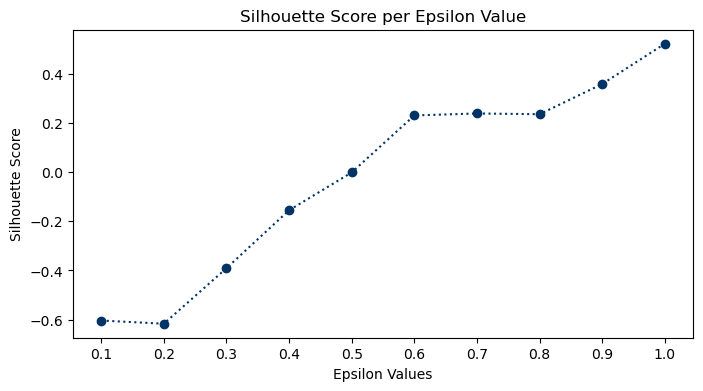

In [757]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_1, sil_scores_1, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_1)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model4a.png');

too many clusters, and low silhouette, try a higher epsilon range.

In [760]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 1.1 and 1.5

epsilon_values_2 = [*np.linspace(1.1, 1.5, 5)]
number_of_clusters_2 = []
number_of_outliers_2 = []
sil_scores_2 = []

for eps in epsilon_values_2:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc1)

    # count and store clusters
    number_of_clusters_2.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_2.append(round(silhouette_score(stocks_sc1, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_2.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_2}')
print(f'Outliers: {number_of_outliers_2}')
print(f'Silhouette Scores: {sil_scores_2}')

Done waiting...
Clusters: [5, 4, 5, 7, 8]
Outliers: [492, 440, 389, 346, 308]
Silhouette Scores: [0.528, 0.687, 0.8, 0.693, 0.623]


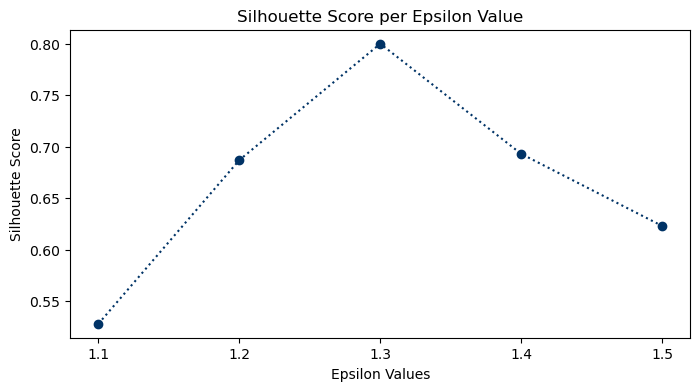

In [762]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_2, sil_scores_2, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_2)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model4b.png');

Check unique stock count for 5 clusters (epsilon 1.3)

In [765]:
dbs1 = DBSCAN(eps = 1.3)
dbs1.fit(stocks_sc1)

DBSCAN(eps=1.3)

In [767]:
set(dbs1.labels_)

{-1, 0, 1, 2, 3}

In [769]:
# store results
results = {
    'clusters': len(set(dbs1.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc1, dbs1.labels_), 3),
    'remarks': 'Cluster D: All numeric features',
    'reference': 'stocks_sc1, dbs1'
}

metrics.append(results)

In [770]:
stocks['cluster_d'] = dbs1.labels_

In [771]:
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c,cluster_d
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2,3,4,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10,9,0,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10,3,4,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10,9,0,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10,8,0,0


In [775]:
# check number of unique stocks per cluster
stocks.groupby('cluster_d')['symbol'].nunique()

cluster_d
-1     57
 0    499
 1      1
 2      1
 3      2
Name: symbol, dtype: int64

---
### **Model 5**

In [778]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_3 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_3 = []
number_of_outliers_3 = []
sil_scores_3 = []

for eps in epsilon_values_3:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc2)

    # count and store clusters
    number_of_clusters_3.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_3.append(round(silhouette_score(stocks_sc2, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_3.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_3}')
print(f'Outliers: {number_of_outliers_3}')
print(f'Silhouette Scores: {sil_scores_3}')

Done waiting...
Clusters: [32, 22, 14, 9, 7, 6, 4, 6, 6, 6]
Outliers: [2038, 813, 492, 355, 263, 215, 200, 163, 133, 115]
Silhouette Scores: [0.082, 0.388, 0.47, 0.615, 0.683, 0.723, 0.754, 0.748, 0.79, 0.842]


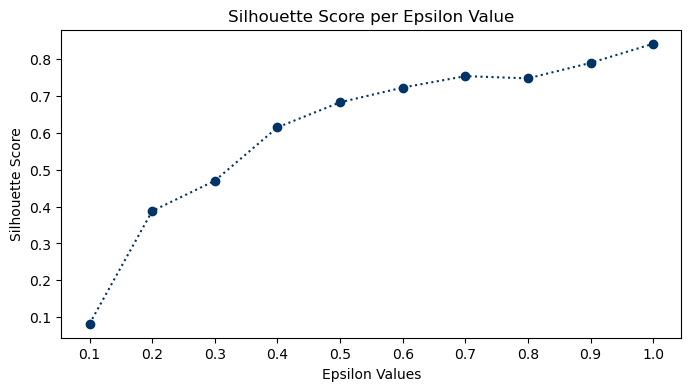

In [780]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_3, sil_scores_3, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_3)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model5.png');

Check unique stock count for 6 clusters (epsilon 1.0)

In [782]:
dbs2 = DBSCAN(eps = 1.0)
dbs2.fit(stocks_sc2)

DBSCAN(eps=1.0)

In [784]:
set(dbs2.labels_)

{-1, 0, 1, 2, 3, 4}

In [786]:
# store results
results = {
    'clusters': len(set(dbs2.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc2, dbs2.labels_), 3),
    'remarks': 'Cluster E: Three engineered features',
    'reference': 'stocks_sc2, dbs2'
}

metrics.append(results)

In [787]:
stocks['cluster_e'] = dbs2.labels_
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2,3,4,0,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10,9,0,0,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10,3,4,0,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10,9,0,0,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10,8,0,0,0


In [790]:
# check number of unique stocks per cluster
stocks.groupby('cluster_e')['symbol'].nunique()

cluster_e
-1     27
 0    503
 1      3
 2      2
 3      5
 4      1
Name: symbol, dtype: int64

---
### **Model 6**

In [793]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_4 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_4 = []
number_of_outliers_4 = []
sil_scores_4 = []

for eps in epsilon_values_4:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc3)

    # count and store clusters
    number_of_clusters_4.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_4.append(round(silhouette_score(stocks_sc3, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_4.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_4}')
print(f'Outliers: {number_of_outliers_4}')
print(f'Silhouette Scores: {sil_scores_4}')

Done waiting...
Clusters: [11, 4, 6, 7, 4, 6, 5, 5, 5, 4]
Outliers: [463, 253, 197, 152, 139, 109, 93, 75, 65, 61]
Silhouette Scores: [0.676, 0.827, 0.797, 0.831, 0.881, 0.86, 0.921, 0.928, 0.927, 0.927]


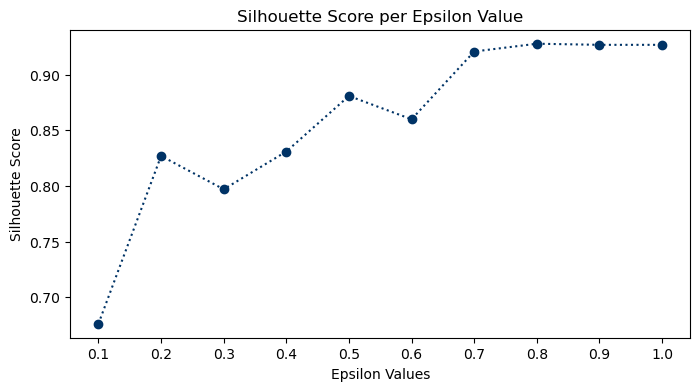

In [795]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_4, sil_scores_4, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_4)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model6.png');

Check unique stock count for 7 clusters (epsilon 0.4)

In [797]:
dbs3 = DBSCAN(eps = 0.4)
dbs3.fit(stocks_sc3)

DBSCAN(eps=0.4)

In [799]:
set(dbs3.labels_)

{-1, 0, 1, 2, 3, 4, 5}

In [801]:
# store results
results = {
    'clusters': len(set(dbs3.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc3, dbs3.labels_), 3),
    'remarks': 'Cluster F: Two engineered features',
    'reference': 'stocks_sc3, dbs3'
}

metrics.append(results)

In [802]:
stocks['cluster_f'] = dbs3.labels_
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e,cluster_f
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,2,3,4,0,0,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,10,9,0,0,0,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,10,3,4,0,0,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,10,9,0,0,0,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,10,8,0,0,0,0


In [805]:
# check number of unique stocks per cluster
stocks.groupby('cluster_f')['symbol'].nunique()

cluster_f
-1     10
 0    502
 1      3
 2      6
 3      2
 4      4
 5      3
Name: symbol, dtype: int64

In [807]:
pd.DataFrame(metrics)

,clusters,n_init,inertia,silhouette,remarks,reference
0,11,20.0,61844.0,0.266,Cluster A: All numeric features,"stocks_sc1, gs1, km1"
1,11,30.0,12193.0,0.377,Cluster B: Three engineered features,"stocks_sc2, gs2, km2"
2,11,30.0,3287.0,0.533,Cluster C: Best Two engineered features,"stocks_sc3, gs3, km3"
3,5,NaN,NaN,0.800,Cluster D: All numeric features,"stocks_sc1, dbs1"
4,6,NaN,NaN,0.842,Cluster E: Three engineered features,"stocks_sc2, dbs2"
5,7,NaN,NaN,0.831,Cluster F: Two engineered features,"stocks_sc3, dbs3"


In [809]:
stocks_by_avg_vol = stocks.groupby('symbol')['volatility'].mean().to_dict()

In [811]:
# save these values in variable v
v = stocks.groupby('symbol')['volatility'].mean().describe(percentiles = [.75, .9])
v

count    503.000000
mean       7.020263
std       13.292745
min        0.277925
50%        4.144717
75%        7.863632
90%       13.937623
max      220.787358
Name: volatility, dtype: float64

In [879]:
print(f"High volatility (high risk) above {round(v['90%'], 2)}")
print(f"Medium volatility (medium risk) between {round(v['75%'], 2)} and below {round(v['90%'], 2)}")
print(f"Low volatility (low risk) below {round(v['75%'], 2)}")

High volatility (high risk) above 13.94
Medium volatility (medium risk) between 7.86 and below 13.94
Low volatility (low risk) below 7.86


In [881]:
high_risk = []
medium_risk = []
low_risk = []

for key, value in stocks_by_avg_vol.items():
    if value > v['90%']:
        high_risk.append(key)
    elif value > v['75%'] and value <= v['90%']:
        medium_risk.append(key)
    else:
        low_risk.append(key)

print(f"Number of high risk stocks: {len(high_risk)}")
print(f"Number of medium risk stocks: {len(medium_risk)}")
print(f"Number of low risk stocks: {len(low_risk)}")

Number of high risk stocks: 51
Number of medium risk stocks: 75
Number of low risk stocks: 377


In [1152]:
def build_portfolios(cluster):
    
    count = stocks[cluster].nunique()
    suffix = cluster[-1]
    
    for i in range(count):
    
        averages = []
        
        if suffix in 'abc':
            for stock in stocks[stocks[cluster] == i]['symbol'].unique():
                averages.append(stocks_by_avg_vol[stock])
                avg = np.mean(averages)
        
        else:
            for stock in stocks[stocks[cluster] == i-1]['symbol'].unique():
                averages.append(stocks_by_avg_vol[stock])
                avg = np.mean(averages)
            
        if avg > v['90%']:
            portfolio = 'high risk'
        elif avg > v['75%'] and value <= v['90%']:
            portfolio = 'medium risk'
        else:
            portfolio = 'low risk'
          
        print(f'Porfolio: {i+1}, Avg. volatility: {round(avg, 2)}')
        print(f'Number of stocks: {len(averages)}, Type: {portfolio}')
        print('-'*40)

In [1154]:
build_portfolios('cluster_d')

Porfolio: 1, Avg. volatility: 21.99
Number of stocks: 57, Type: high risk
----------------------------------------
Porfolio: 2, Avg. volatility: 6.19
Number of stocks: 499, Type: low risk
----------------------------------------
Porfolio: 3, Avg. volatility: 5.94
Number of stocks: 1, Type: low risk
----------------------------------------
Porfolio: 4, Avg. volatility: 17.63
Number of stocks: 1, Type: high risk
----------------------------------------
Porfolio: 5, Avg. volatility: 108.71
Number of stocks: 2, Type: high risk
----------------------------------------
